In [1]:
# import sys
# sys.path.append('../qick/qick_lib/')
from qick import *

# from test_phase import *

# import numpy as np

# import matplotlib.pyplot as plt
# from numpy.fft import fft, fftshift
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc('./test_phase.bit', ignore_version=True, force_init_clks=False)

soccfg = soc
print(soccfg)


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	4 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=614.400 MHz, fs=9830.400 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=614.400 MHz, fs=9830.400 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=614.400 MHz, fs=9830.400 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=614.400 MHz, fs=9830.400 MHz

	2 readout channels:
	0:	axis_readout_v3 - controlled by tProc output 4
		ADC tile 2, ch 0, 32-bit DDS, fabric=614.400 MHz, fs=2457.600 MHz
		maxlen 1024 (avg) 1024 (decimated), trigger bit 4, tProc input 0
	1:	axis_readout_v2 - controlled by PYNQ
		ADC tile 2, ch 2, 32-bit DDS, fabric=307.200 MHz, fs=2457.600

In [3]:
def findPeak(x,y,xmin=-1,xmax=-1):
    if xmin == -1:
        xmin = np.min(x)        
    if xmax == -1:
        xmax = np.max(x)        

    imin = np.argwhere(x <= xmin)
    imin = imin[-1].item()
    imax = np.argwhere(x >= xmax)
    imax = imax[0].item()

    # Find max.
    idxmax = np.argmax(y[imin:imax]) + imin

    # x, y.
    Xmax = x[idxmax].item()
    Ymax = y[idxmax].item()

    return Xmax, Ymax 

The readout control works very much like the generator control.

The readout is technically only configured during the window defined by the length and mode; however, it seems that the configuration remains active after the end of the window.
Practically speaking, best practice in most cases should be to use `mode='oneshot'` (this is default, so you can omit it) and a very short length.

You of course need to ensure that the readout config you need is applied before your readout gets used. If you have a complicated setup and this is in doubt, you should test.

For correct phase-reset synchronization, all phase resets should be sent on the same tProc clock tick.

In [4]:
class PhaseExample(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch0 = cfg["res_ch0"]
        res_ch1 = cfg["res_ch1"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch0"], nqz=1)
        self.declare_gen(ch=cfg["res_ch1"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            if self.soccfg['readouts'][ch]['tproc_ctrl'] is None:
                self.declare_readout(ch=ch, length=cfg["readout_length"],
                                     freq=cfg["pulse_freq"], gen_ch=cfg["res_ch0"])
            else:
                self.declare_readout(ch=ch, length=cfg["readout_length"])
                freq_ro = self.freq2reg_adc(cfg["pulse_freq"],ro_ch=ch,gen_ch=cfg['res_ch0'])
                self.set_readout_registers(ch=ch, freq=freq_ro, length=3,
                                           mode='oneshot', outsel='product', phrst=1)



        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch0)
        gain = cfg["pulse_gain"]

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch0, name="measure0", sigma=sigma, length=sigma*5)
            self.add_gauss(ch=res_ch1, name="measure1", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.default_pulse_registers(ch=res_ch0, style=style, freq=freq, gain=gain, length=cfg["length"])
            self.default_pulse_registers(ch=res_ch1, style=style, freq=freq, gain=gain, length=cfg["length"])        
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.default_pulse_registers(ch=res_ch0, style=style, freq=freq, gain=gain, 
                                         waveform="measure0", length=cfg["length"])
            self.default_pulse_registers(ch=res_ch1, style=style, freq=freq, gain=gain, 
                                         waveform="measure1", length=cfg["length"])
        elif style == "arb":
            self.default_pulse_registers(ch=res_ch0, style=style, freq=freq, gain=gain, 
                                         waveform="measure0")
            self.default_pulse_registers(ch=res_ch1, style=style, freq=freq, gain=gain, 
                                         waveform="measure1")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        phase = self.deg2reg(self.cfg["pulse_phase"], gen_ch=self.cfg["res_ch1"])
        self.set_pulse_registers(ch=self.cfg["res_ch0"], phase=0, phrst=1,mode="oneshot")
        self.set_pulse_registers(ch=self.cfg["res_ch1"], phase=0, phrst=0, mode="periodic")
        
        self.measure(pulse_ch=self.cfg["res_ch0"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     t=0,
                     wait=False)
        
        # Configure readout v3.
        for ch in self.cfg["ro_chs"]:
            if self.soccfg['readouts'][ch]['tproc_ctrl'] is not None:
                self.readout(ch=ch, t=0)

        
config={"res_ch0":0, # --Fixed
        "res_ch1":2, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "pulse_style": "const", # --Fixed
        "length":100, # [Clock ticks]
        "pulse_gain":30000, # [DAC units]
        "pulse_freq": 1000, # [MHz]
        "pulse_phase": 0,
        "readout_length":500, # [Clock ticks]
        "adc_trig_offset": 0, # [Clock ticks]
        "relax_delay":0.0, # --us
        "soft_avgs":1
       }

prog = PhaseExample(soccfg, config)

print(prog)

# load this program into the soc's tproc
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)



// Program

        regwi 2, $22, 436906667;                //freq = 1747626668
        bitwi 2, $22, $22 << 2;
        regwi 2, $26, 524291;                   //mode | outsel = 0b01000 | length = 3 
        regwi 0, $22, 436906667;                //freq = 436906667
        regwi 0, $25, 30000;                    //gain = 30000
        regwi 1, $22, 436906667;                //freq = 436906667
        regwi 1, $25, 30000;                    //gain = 30000
        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 0;
LOOP_J: regwi 0, $23, 0;                        //phase = 0
        regwi 0, $26, 1638500;                  //stdysel | mode | outsel = 0b11001 | length = 100 
        regwi 1, $23, 0;                        //phase = 0
        regwi 1, $26, 852068;                   //stdysel | mode | outsel = 0b01101 | length = 100 
        regwi 0, $31, 17;                       //out = 0b0000000000010001
        seti 7, 0, $31, 0;                      //ch =0 out = $31 @t = 0
  

  0%|          | 0/1 [00:00<?, ?it/s]

Phase: 0.9979788072401709
F1: 0.000, Y1: 110.057


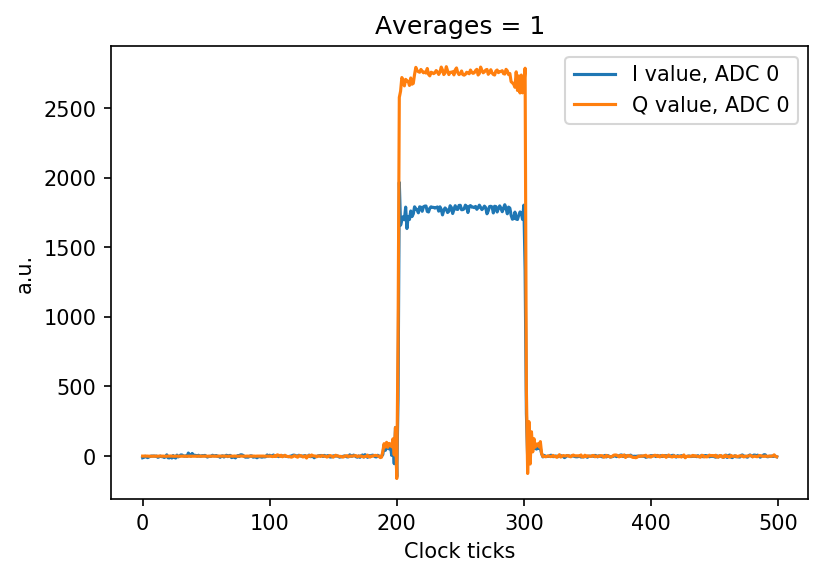

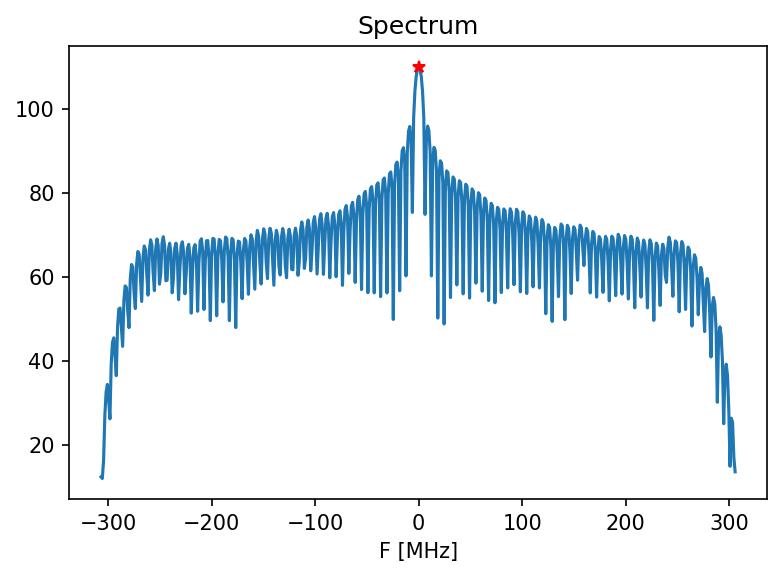

In [5]:
from numpy.fft import fft, fftshift

# Plot results.
plt.figure(1,dpi=150)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    #plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()

# Phase.
i0 = 220
i1 = 280
iMean = iq[0][i0:i1].mean()
qMean = iq[1][i0:i1].mean()
ai = np.abs(iMean + 1j*qMean)
fi = np.angle(iMean + 1j*qMean)
print("Phase: {}".format(fi))

fs = soc.adcs['20']['fs']/4
x = iq[0] + 1j*iq[1]
w = np.hanning(len(x))
xw = x*w
F = (np.arange(len(x))/len(x)-0.5)*fs
Y = fftshift(fft(xw))
Y = 20*np.log10(abs(Y))

[F1,Y1] = findPeak(F,Y);

plt.figure(2,dpi=150)
plt.plot(F,Y)
plt.plot(F1,Y1,'r*');
plt.title("Spectrum");
plt.xlabel("F [MHz]");

print("F1: {:.3f}, Y1: {:.3f}".format(F1,Y1))

  0%|          | 0/1 [00:00<?, ?it/s]

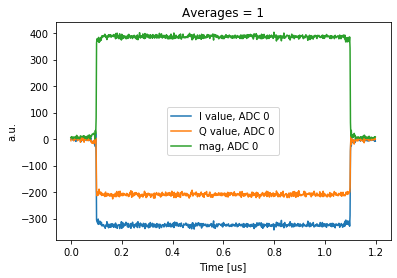

In [25]:
class SingleGenLoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        style = cfg['style']
        
        for iCh, ch in enumerate([cfg["res_ch"]]):  # configure the readout lengths and downconversion frequencies
            length_gen = self.us2cycles(cfg['length'], gen_ch=ch)
            self.declare_gen(ch=ch, nqz=1, ro_ch=cfg["ro_ch"])
            self.default_pulse_registers(ch=ch, 
                         freq=self.freq2reg(cfg["pulse_freq"],gen_ch=ch,ro_ch=cfg["ro_ch"]),
                         gain=cfg['pulse_gain'],
                         phase=0)
            if style == "const":
                self.set_pulse_registers(ch=ch, style=style, length=length_gen)
            elif style == "arb":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/5, length=length_gen)
                self.set_pulse_registers(ch=ch, style=style, waveform="measure")
            elif style == "flat_top":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/25, length=int(0.2*length_gen))
                self.set_pulse_registers(ch=ch, style=style, waveform="measure", length=int(0.8*length_gen))

        for iCh, ch in enumerate([cfg["ro_ch"]]):  # configure the readout lengths and downconversion frequencies
            length_ro = soccfg.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=ch)
            self.declare_readout(ch=ch, length=length_ro)
            freq_ro = self.freq2reg_adc(cfg["pulse_freq"],ro_ch=ch,gen_ch=cfg['res_ch'])
            self.set_readout_registers(ch=ch, freq=freq_ro, length=5)


        self.synci(200)  # give processor some time to configure pulses

    def body(self):
#         # Configure readout v3.
        for ch in [self.cfg["ro_ch"]]:
            if self.soccfg['readouts'][ch]['tproc_ctrl'] is not None:
                self.readout(ch=ch, t=0)
                
        self.measure(pulse_ch=self.cfg["res_ch"],
                     t=0,
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]-0.5*self.cfg['readout_padding']),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

config={"res_ch":0, # --Fixed
        "ro_ch":0, # --Fixed
        'adc_trig_offset': 0.33,
        'readout_padding': 0.2,
        'relax_delay': 1,
        "pulse_gain":3000, # [DAC units]
        "pulse_freq": 500, # [MHz]
#         'style': 'arb',
        'style': 'const',
#         'style': 'flat_top',
        'length': 1, # [us]
        'reps': 1,
        'soft_avgs': 1
       }

# config['readout_padding'] = 0.1
prog = SingleGenLoopbackProgram(soccfg, config)
# print(prog)

iq_list = prog.acquire_decimated(soc, progress=True)
# Plot results.
def plot_decimated(iq_list, soccfg, config, plot_iq=True):
#     fig, axs = plt.subplots(2,1,figsize=(10,10))
    t = soccfg.cycles2us(np.arange(len(iq_list[0][0])), ro_ch=config['ro_ch'])

    for ii, iq in enumerate(iq_list):
#         plot = axs[ii]
        if plot_iq:
            plt.plot(t, iq[0], label="I value, ADC %d"%(config['ro_ch']))
            plt.plot(t, iq[1], label="Q value, ADC %d"%(config['ro_ch']))
            plt.plot(t, np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_ch']))
        else:
            plt.plot(t, iq[0], label="input value, ADC %d"%(config['ro_ch']))
        plt.ylabel("a.u.")
        plt.xlabel("Time [us]")
        plt.title("Averages = " + str(config["soft_avgs"]))
        plt.legend()
plot_decimated(iq_list, soccfg, config, plot_iq=True)

  0%|          | 0/40100 [00:00<?, ?it/s]

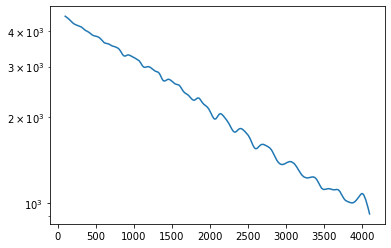

In [70]:
class SweepProgram(RAveragerProgram):
    def initialize(self):
        cfg = self.cfg
        style = cfg['style']
        
        self.ro_rp=self.ch_page_ro(cfg["ro_ch"])     # get register page for ro_ch
        self.ro_freq=self.sreg_ro(cfg["ro_ch"], "freq")   #Get gain register for ro_ch
        
        self.gen_rp=self.ch_page(cfg["res_ch"])     # get register page for res_ch
        self.gen_freq=self.sreg(cfg["res_ch"], "freq")   #Get gain register for res_ch

        
        for iCh, ch in enumerate([cfg["res_ch"]]):  # configure the readout lengths and downconversion frequencies
            length_gen = self.us2cycles(cfg['length'], gen_ch=ch)
            self.declare_gen(ch=ch, nqz=1, ro_ch=cfg["ro_ch"])
            self.default_pulse_registers(ch=ch, 
                         freq=cfg['start'],
                         gain=cfg['pulse_gain'],
                         phase=0)
            if style == "const":
                self.set_pulse_registers(ch=ch, style=style, length=length_gen)
            elif style == "arb":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/5, length=length_gen)
                self.set_pulse_registers(ch=ch, style=style, waveform="measure")
            elif style == "flat_top":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/25, length=int(0.2*length_gen))
                self.set_pulse_registers(ch=ch, style=style, waveform="measure", length=int(0.8*length_gen))

        for iCh, ch in enumerate([cfg["ro_ch"]]):  # configure the readout lengths and downconversion frequencies
            length_ro = soccfg.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=ch)
            self.declare_readout(ch=ch, length=length_ro)
#             freq_ro = self.freq2reg_adc(cfg["pulse_freq"],ro_ch=ch,gen_ch=cfg['res_ch'])
            self.set_readout_registers(ch=ch, freq=cfg['start']*4, length=5)


        self.synci(200)  # give processor some time to configure pulses

    def body(self):
#         # Configure readout v3.
        for ch in [self.cfg["ro_ch"]]:
            if self.soccfg['readouts'][ch]['tproc_ctrl'] is not None:
                self.readout(ch=ch, t=0)
                
        self.measure(pulse_ch=self.cfg["res_ch"],
                     t=0,
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]-0.5*self.cfg['readout_padding']),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

    def update(self):
        self.mathi(self.ro_rp, self.ro_freq, self.ro_freq, '+', self.cfg["step"]*4) # update RO freq
        self.mathi(self.gen_rp, self.gen_freq, self.gen_freq, '+', self.cfg["step"]) # update gen freq

config={"res_ch":0, # --Fixed
        "ro_ch":0, # --Fixed
        'adc_trig_offset': 0.33,
        'readout_padding': 0.2,
        'relax_delay': 1,
        "pulse_gain":30000, # [DAC units]
        "pulse_freq": 500, # [MHz]
#         'style': 'arb',
        'style': 'const',
#         'style': 'flat_top',
        'length': 10, # [us]
        'soft_avgs': 1,
        'reps': 100,
        "expts": 401,
        "start":prog.freq2reg(f=100,ro_ch=0,gen_ch=0), # [DAC units]
        "step":prog.freq2reg(f=10,ro_ch=0,gen_ch=0) # [DAC units]
       }

# the start and step must both be scaled by 4 between the gen and RO.

# config['readout_padding'] = 0.1
prog = SweepProgram(soccfg, config)
# print(prog)

expt_pts, di, dq = prog.acquire(soc, progress=True)

freqs = soccfg.reg2freq(expt_pts, gen_ch=0)
plt.semilogy(freqs, np.abs((di+1j*dq)[0,0]))

In [36]:
print(prog.freq2reg_adc(f=100,ro_ch=0,gen_ch=0))
print(prog.freq2reg(f=100,ro_ch=0,gen_ch=0))

174762668
43690667
